# Let's decompose time series data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import boxcox
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [2]:
def plot_p(df, column, title, ylabel):
    '''
    The function plot_p helps me to plot the number of passengers over time.
    
    -----------
    Parameters:
    df: DataFrame that works as basis of the plot
    column: The column that is plotted on the y-axis
    title: The title of the plot
    ylabel: The lable of the y-axis
    '''
    df[column].plot(figsize=(12, 8))
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.show()

In [3]:
df['Date'] = pd.to_datetime(df.month.astype(str) + '-' + df.year.astype(str))
df.set_index('Date', inplace=True)
df.head()

,year,month,passengers
Date,,,
1949-01-01,1949,January,112
1949-02-01,1949,February,118
1949-03-01,1949,March,132
1949-04-01,1949,April,129
1949-05-01,1949,May,121


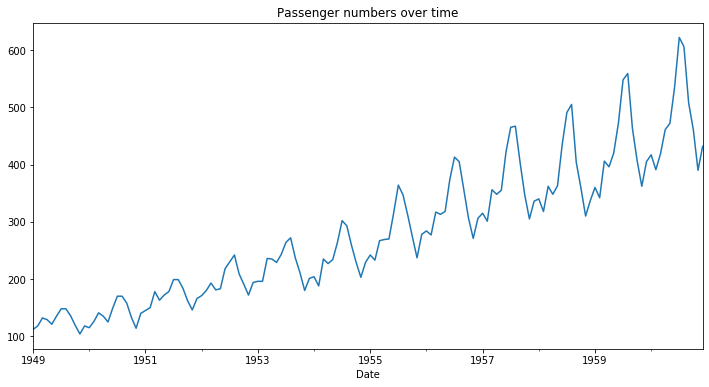

In [4]:
df.passengers.plot(figsize=(12,6), title='Passenger numbers over time')
plt.show()

## 1) Remove the trend

- Differencing - if the trend is linear
- Second order differencing - if the trend is exponential
- Take the rolling mean and subtract it

### Differencing

In [5]:
#Linear
df['difference'] = df['passengers'].diff()
df.head()

,year,month,passengers,difference
Date,,,,
1949-01-01,1949,January,112,NaN
1949-02-01,1949,February,118,6.0
1949-03-01,1949,March,132,14.0
1949-04-01,1949,April,129,-3.0
1949-05-01,1949,May,121,-8.0


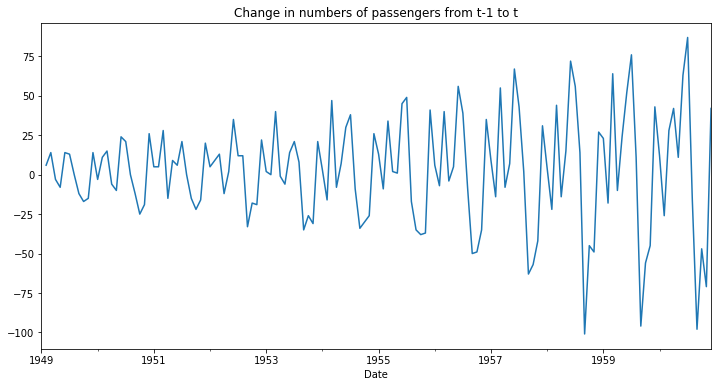

In [6]:
df['difference'].plot(figsize=(12,6), title='Change in numbers of passengers from t-1 to t')
plt.show()

In [29]:
df['difference'].mean()

2.237762237762238

## Second order differencing

In [7]:
df['2nddifference'] = df['difference'].diff()
df.head()

,year,month,passengers,difference,2nddifference
Date,,,,,
1949-01-01,1949,January,112,NaN,NaN
1949-02-01,1949,February,118,6.0,NaN
1949-03-01,1949,March,132,14.0,8.0
1949-04-01,1949,April,129,-3.0,-17.0
1949-05-01,1949,May,121,-8.0,-5.0


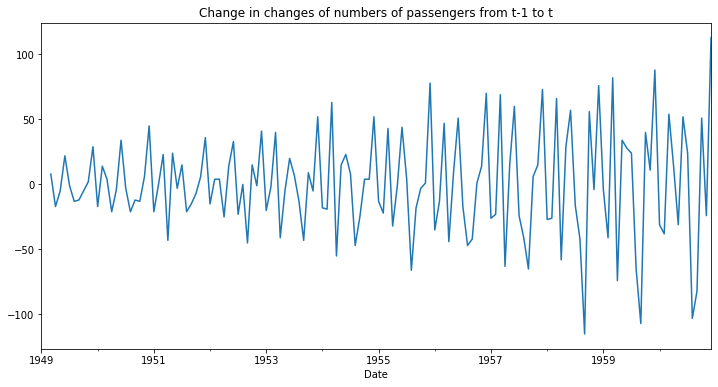

In [8]:
df['2nddifference'].plot(figsize=(12,6), title='Change in changes of numbers of passengers from t-1 to t')

In [9]:
df['2nddifference'].mean()

0.2535211267605634

## Take the rolling mean and subtract it from the data

In [10]:
df['rolling'] = df.passengers.rolling(12, center=True).mean()
df.head()

,year,month,passengers,difference,2nddifference,rolling
Date,,,,,,
1949-01-01,1949,January,112,NaN,NaN,NaN
1949-02-01,1949,February,118,6.0,NaN,NaN
1949-03-01,1949,March,132,14.0,8.0,NaN
1949-04-01,1949,April,129,-3.0,-17.0,NaN
1949-05-01,1949,May,121,-8.0,-5.0,NaN


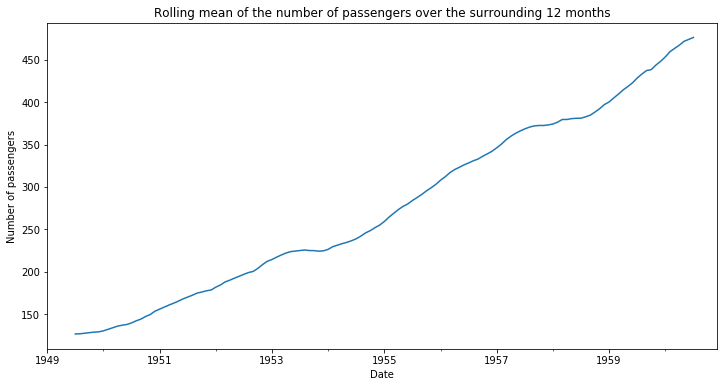

In [11]:
df['rolling'].plot(figsize=(12, 6))
plt.title('Rolling mean of the number of passengers over the surrounding 12 months')
plt.ylabel('Number of passengers')
plt.xlabel('Date')
plt.show()

In [12]:
df['de-trended'] = df.passengers - df['rolling']
df.head()

,year,month,passengers,difference,2nddifference,rolling,de-trended
Date,,,,,,,
1949-01-01,1949,January,112,NaN,NaN,NaN,NaN
1949-02-01,1949,February,118,6.0,NaN,NaN,NaN
1949-03-01,1949,March,132,14.0,8.0,NaN,NaN
1949-04-01,1949,April,129,-3.0,-17.0,NaN,NaN
1949-05-01,1949,May,121,-8.0,-5.0,NaN,NaN


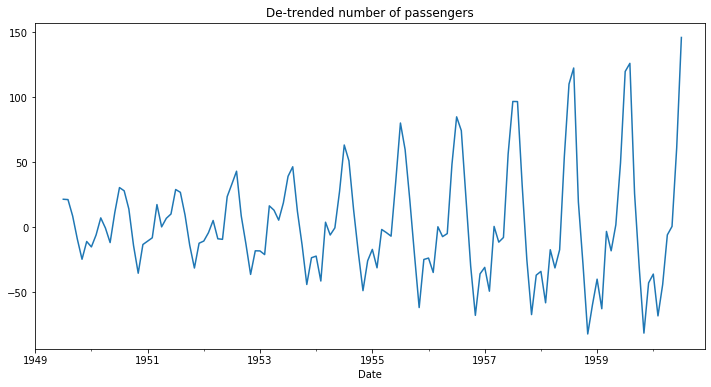

In [13]:
df['de-trended'].plot(figsize=(12,6), title='De-trended number of passengers')

### Take out the change in volatility by taking the logarithm of the time series

In [14]:
df['log_y'] = np.log(df.passengers)
df['log_diff'] = df.log_y.diff()
df.head()

,year,month,passengers,difference,2nddifference,rolling,de-trended,log_y,log_diff
Date,,,,,,,,,
1949-01-01,1949,January,112,NaN,NaN,NaN,NaN,4.718499,NaN
1949-02-01,1949,February,118,6.0,NaN,NaN,NaN,4.770685,0.052186
1949-03-01,1949,March,132,14.0,8.0,NaN,NaN,4.882802,0.112117
1949-04-01,1949,April,129,-3.0,-17.0,NaN,NaN,4.859812,-0.022990
1949-05-01,1949,May,121,-8.0,-5.0,NaN,NaN,4.795791,-0.064022


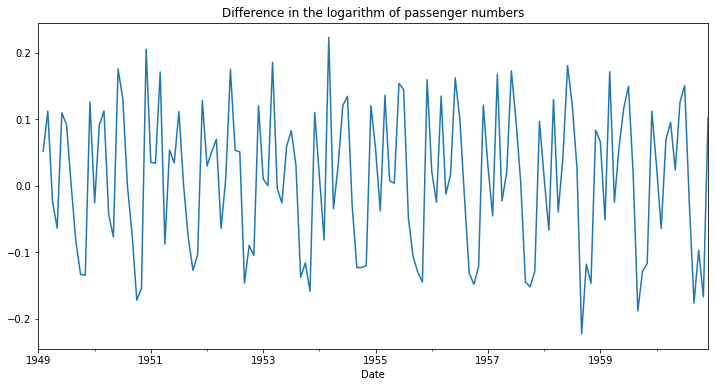

In [15]:
df['log_diff'].plot(figsize=(12,6), title='Difference in the logarithm of passenger numbers')
plt.show()

### Take out seasonality

Demean each value by subtracting the monthly mean

In [16]:
df['monthly_mean'] = df.groupby('month')['log_diff'].transform('mean') # Just mean gives you len = 12
#.transform('mean') simply puts monthly means in the right place
df['de-seasonalized'] = df['log_diff'] - df['monthly_mean']

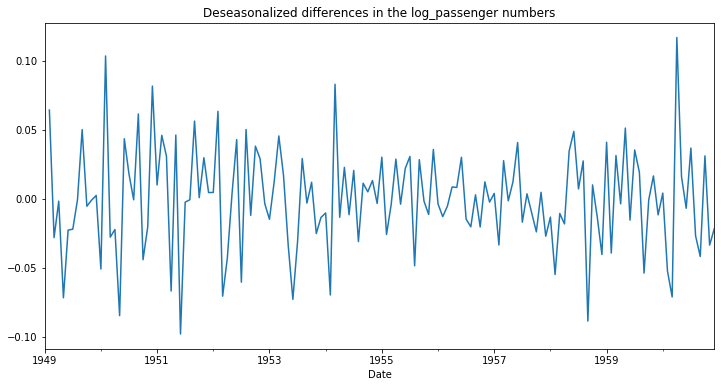

In [17]:
df['de-seasonalized'].plot(figsize=(12,6), title='Deseasonalized differences in the log_passenger numbers')

## This is the time series we will actually do our analysis on!

1. We make predictions for the df['de-seasonalized']
- We add back on the monthly_mean
- We take the first value and create whole log_series
- We exponentiate the values to arrive back at the acutal values

In [18]:
df.head()

,year,month,passengers,difference,2nddifference,rolling,de-trended,log_y,log_diff,monthly_mean,de-seasonalized
Date,,,,,,,,,,,
1949-01-01,1949,January,112,NaN,NaN,NaN,NaN,4.718499,NaN,0.025154,NaN
1949-02-01,1949,February,118,6.0,NaN,NaN,NaN,4.770685,0.052186,-0.011986,0.064172
1949-03-01,1949,March,132,14.0,8.0,NaN,NaN,4.882802,0.112117,0.140296,-0.028179
1949-04-01,1949,April,129,-3.0,-17.0,NaN,NaN,4.859812,-0.022990,-0.021200,-0.001789
1949-05-01,1949,May,121,-8.0,-5.0,NaN,NaN,4.795791,-0.064022,0.007696,-0.071718


In [19]:
# 2. add back the monthly mean
reconstruct = df['de-seasonalized'] + df.monthly_mean
reconstruct

Date
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
1949-12-01    0.126294
1950-01-01   -0.025752
1950-02-01    0.091350
1950-03-01    0.112478
1950-04-01   -0.043485
1950-05-01   -0.076961
1950-06-01    0.175633
1950-07-01    0.131852
1950-08-01    0.000000
1950-09-01   -0.073203
1950-10-01   -0.172246
1950-11-01   -0.154151
1950-12-01    0.205444
1951-01-01    0.035091
1951-02-01    0.033902
1951-03-01    0.171148
1951-04-01   -0.088033
1951-05-01    0.053744
1951-06-01    0.034289
                ...   
1958-07-01    0.121098
1958-08-01    0.028114
1958-09-01   -0.223144
1958-10-01   -0.118092
1958-11-01   -0.146750
1958-12-01    0.083511
1959-01-01    0.066021
1959-02-01   -0.051293
1959-03-01    0.171542
1959-04-01   -0.024939
1959-05-01    0.058841
1959-06-01    0.116724
1959-0

In [20]:
# 3. Take the whole series and recreate the whole log series
reconstruct[0] = df.log_y[0]
reconstruct.head()

Date
1949-01-01    4.718499
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
dtype: float64

In [21]:
reconstruct = reconstruct.cumsum()
reconstruct.head()

Date
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
dtype: float64

In [22]:
# 4. We exponentiate the values to arrive back at the acutal values
reconstruct = np.exp(reconstruct)
reconstruct.head()

Date
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
dtype: float64

## Introduce time series package

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

Additive model

Figure(432x288)


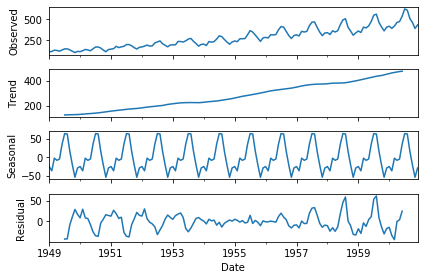

In [24]:
decompose = seasonal_decompose(df['passengers'], model='additive')
print(decompose.plot())

In [27]:
decompose.resid[20:40]

Date
1950-09-01    -4.228535
1950-10-01     5.226010
1950-11-01    16.051768
1950-12-01    13.911616
1951-01-01    12.623737
1951-02-01    26.646465
1951-03-01    18.407828
1951-04-01     6.911616
1951-05-01     9.839646
1951-06-01   -26.486111
1951-07-01   -36.080808
1951-08-01   -37.406566
1951-09-01    -7.978535
1951-10-01     5.809343
1951-11-01    21.551768
1951-12-01    14.453283
1952-01-01    12.623737
1952-02-01    29.979798
1952-03-01     6.199495
1952-04-01    -2.255051
Name: passengers, dtype: float64

Figure(432x288)


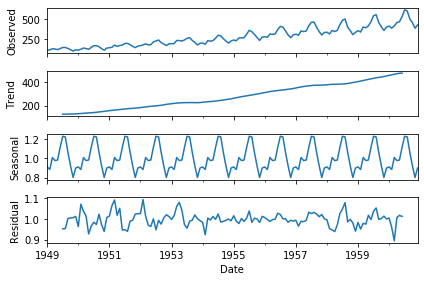

In [28]:
decompose = seasonal_decompose(df['passengers'], model='multiplicative')
print(decompose.plot())